# Create DM-model using GModelSpectralTable

The DM-induced photon spectra is complex and can not be modeled using analytic formula (at least of the spectrum computed from generators as Pythia).

In gammalib, such complex spectra can be managed using the [**GModelSpectralTable**](http://cta.irap.omp.eu/gammalib/users/user_manual/modules/model/sky/spectral.html#table-model). In this  this notebook you can learn how to create, save and manage a DM model using this class.

We use the dmspectrum class to compute the number of photons at some energy. See [dmspec_example](https://github.com/sergiohcdna/ctaAnalysis/blob/development/examples/dmspec_example.py). You can adapt the script to read directly from the *.dat* files or use your preferred interpolator package.

We create the GModelSpectralTable using the DM mass of the candidate, and the annihilation channel as (fixed) parameters. Also, GModelSpectralTable requires that all the values of the spectra are computed over the same energy range, so we increase the number of energy bins in order to have *sufficient* number of points for candidates with masses $\thicksim100 GeV$.

As in the GSpectralFunc, the GModelSpectralTable accept a normalization parameter, **Normalization**, where the information of the astrophysical factor and the cross-section is encapsulated(?).

Thanks to Jürgen and Luigi for the help and discussion about this example.


In [1]:
import gammalib
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from ctaAnalysis.dmspectrum.dmspectra import dmspectrum

First, we define some quantities related to energy extension in the **GModelSpectralTable**:

- Number of energy bins
- Min energy $E_{\text{min}}$ (in GeV)
- Max energy $E_{\text{min}}$ (in GeV)


In [2]:
nebins = 150                                      # Number of bins
emin   = gammalib.GEnergy(30.0, 'GeV')            # E_min
emax   = gammalib.GEnergy(100.0, 'TeV')           # E_max
ebins  = gammalib.GEbounds(nebins, emin, emax)    # Array with definitions of energy bins


I need a numpy array for the energies, too. This is required by the `dmspectrum` class.

In [3]:
energies = np.zeros((nebins))
for i in range(nebins):
    energies[i] = ebins.elogmean(i).GeV()


Next, define the value of masses needed to compute the photon spectrum

In [4]:
masses = [100.0, 115.0, 133.0, 155.0, 176.0, 202.0, 233.0, 268.0, 309.0, 356.0, 410.0, 470.0,
          543.0, 625.0, 720.0, 829.0, 954.0, 1100.0, 1265.0, 1455.0, 1677.0, 1930.0, 2223.0,
          2560.0, 2947.0, 3393.0, 3907.0, 4500.0, 5180.0, 5965.0, 6866.0, 7906.0, 9105.0,
          10480.0, 12068.0, 13895.0, 16000.0, 18420.0, 21210.0, 24420.0, 28120.0,
          32375.0, 37275.0, 42920.0, 49417.0, 56900.0, 65515.0, 75430.0, 86850.0, 100000.0]

Now, I define some quantities required to create an instance of `dmspectrum` class

In [5]:
eblmodel = 'dominguez'
channel  = 'Tau'
redshift = 0.028

In this cell, I put some definitions for the Table parameters and the GNdarray to save the spectrum data

Remember that, the spectrum for the different masses is computed over the same energy range $[30.0\text{GeV}, 100\text{GeV}]$ then, for example for a mass $m=150\text{TeV}$, for energies $E>m$ the spectrum $\mathrm{d}N/\mathrm{d}E$ will be zero.

In [6]:
# The parameter is defined with (name, factor_value, scale)
dmmass   = gammalib.GModelPar('Mass', 1.0e+3)
dmmass.unit('GeV')
par_mass = gammalib.GModelSpectralTablePar(dmmass, masses)
pars     = gammalib.GModelSpectralTablePars()
pars.append(par_mass)
spectra  = gammalib.GNdarray(len(masses), nebins)

In [7]:
for index, mass in enumerate(masses):
    #    Create an instance of dmspectrum
    dminterp = dmspectrum(mass, energies, channel, redshift, eblmod=eblmodel)
    spec     = dminterp.spectra()
    for eindex in range(nebins):
        spectra[index, eindex] = spec[eindex]

model = gammalib.GModelSpectralTable(ebins, pars, spectra)
model.table_par('Mass').method(0)
model.save('DM_tau.fits', True)

## Reading the table model

In [8]:
tmodel = gammalib.GModelSpectralTable()
tmodel.load('DM_tau.fits')
print(tmodel)

=== GModelSpectralTable ===
 Table file ................: DM_tau.fits
 Number of parameters ......: 2
  Normalization ............: 1 +/- 0 [0,1000]  (free,scale=1,gradient)
  Mass .....................: 1000 +/- 0 [100,100000]  (free,scale=1000,gradient)
 Mass values ...............: 50 [100, 100000] (linear)
 Energies ..................: 150 [30 GeV, 99.999997952 TeV]
 Spectra array dimension ...: 2
 Number of spectra .........: 50
 Number of spectral bins ...: 150


You can change the value of the mass of the dark matter candidate, and `GModelSpectralTable` compute the spectrum at this new value. Also you can pass the value of the prefactor $N=\frac{\langle\sigma v\rangle}{8\pi m}\times J$

In [9]:
#   checking spectra for mass = 175 GeV
mymass = 175
par_m  = tmodel['Mass']
par_m.value(mymass)

par_norm = tmodel['Normalization']
j        = 1.e+18
sigmav   = 3.0e-26
mynorm   = sigmav / 8 / gammalib.pi / mymass / mymass * j
par_norm.value(mynorm)

nemin  = 35  # in GeV
nemax  = 200 # in GeV
nbins  = 50  # number of bins
dnde_a = []  # to save the spectrum
elogspace = np.logspace(np.log10(nemin), np.log10(nemax), nbins)
for n, energy in enumerate(elogspace):
    echeck = gammalib.GEnergy(energy,'GeV')
    tdnde  = tmodel.eval(echeck)
    dnde_a.append(tdnde)

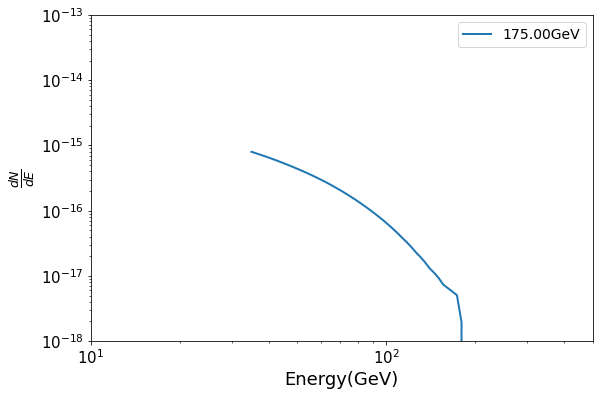

In [10]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(elogspace, dnde_a, label='{:.2f}GeV'.format(mymass), lw=2)
ax.set_xlim(nemin,nemax)
ax.set_xlim(10.0,5.0e+2)
ax.set_ylim(1.0e-18,1.0e-13)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Energy(GeV)', fontsize=18)
ax.set_ylabel('$\\frac{dN}{dE}$', fontsize=18)
ax.legend(loc='best', prop={'size':14})
ax.tick_params(labelsize=15)

You can define a source model as usual

In [11]:
srcname = 'ToyDH'
ra      = 188.0   # in degrees
dec     = 12.5    # in degrees

spatial = gammalib.GModelSpatialPointSource(ra, dec)

In [12]:
par_m.fix() # Fix parameter mass

In [13]:
# And now, the GModelSky
dmmodel = gammalib.GModelSky(spatial, tmodel)
dmmodel.name(srcname)

In [14]:
#   spectral correction
spectral = gammalib.GModelSpectralPlaw(1, 0, gammalib.GEnergy(1, 'TeV'))

# create background model
bkgmodel = gammalib.GCTAModelIrfBackground(spectral)
bkgmodel.name('Background')
bkgmodel.instruments('CTA')

In [15]:
models = gammalib.GModels()
models.append(dmmodel)
models.append(bkgmodel)
print(models)

=== GModels ===
 Number of models ..........: 2
 Number of parameters ......: 9
=== GModelSky ===
 Name ......................: ToyDH
 Instruments ...............: all
 Observation identifiers ...: all
 Model type ................: PointSource
 Model components ..........: "PointSource" * "TableModel" * "Constant"
 Number of parameters ......: 5
 Number of spatial par's ...: 2
  RA .......................: 188 deg (fixed,scale=1)
  DEC ......................: 12.5 deg (fixed,scale=1)
 Number of spectral par's ..: 2
  Normalization ............: 3.89767207571989e-14 +/- 0 [0,1000]  (free,scale=1,gradient)
  Mass .....................: 175 [100,100000]  (fixed,scale=1000,gradient)
 Number of temporal par's ..: 1
  Normalization ............: 1 (relative value) (fixed,scale=1,gradient)
 Number of scale par's .....: 0
=== GCTAModelIrfBackground ===
 Name ......................: Background
 Instruments ...............: CTA
 Observation identifiers ...: all
 Model type ................: "Pow